<a href="https://colab.research.google.com/github/pedro-cardoso16/Super-Resolution/blob/main/super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy Example

First be sure the notebook is running with GPU.

Runtime -> Change Runtime Type -> GPU

In [1]:
# Colab only
# download and install Pytorch
%pip install torch torchvision
%pip install numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F

import math


In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [4]:
# load the image, convert it as an array of float, and divide to have [0,1] values
# path to the image on the drive
image_filename = "/content/gdrive/My Drive/foulard1-bis.jpg"

im = np.array(Image.open(image_filename), dtype=float)/255

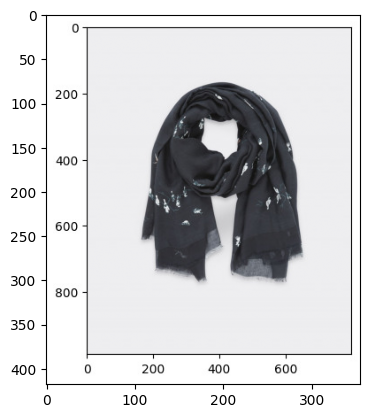

In [5]:
# display the original images
plt.figure()
plt.imshow(im)
plt.show()

In [6]:
# convert to torch with batch dimension as first dimension
image = torch.from_numpy(im.transpose(2,0,1)).float().unsqueeze(0)
print(image.shape)


torch.Size([1, 3, 418, 355])


## Neural network creation

The neural network is a Python class, it must inherit from the ```torch.nn.Module``` class of Pytorch.

It is composed of two main methods:
* ```__init__```, the contructor which define the layers to be used. The layers contain the paramters to be optimized
* ```forward```,  the method that define the links between the layers

As an example, we create a network based on UNet, a semantic segmeentation network.
This network has an encoder / decoder strcuture with skip connection.

To do Super Resolution, we simply use add a last block with one dimension augmentation (```upconv0```).

In [7]:
# create the neural network with Pytorch
class Mynet(nn.Module):
  """Unet segmentation network."""

  def __init__(self, in_channels, out_channels):
    """Init Unet fields."""
    super(Mynet, self).__init__()

    self.in_channels = in_channels

    self.conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(3)


  def forward(self, x):
    """Forward method."""

    x = F.relu(self.bn(self.conv(x)))
    x = F.relu(self.bn2(self.conv2(x)))

    return x

In [8]:
# actual network creation
net = Mynet(3,3)
net.cuda() # go GPU

image = image.cuda() # go gpu for the image data


## Optimization

There are two steps.
First we create the optimizer and then, we loop over the dataset (here, only one image) 1000 times and optimize the network weights.

In [9]:
# create the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)

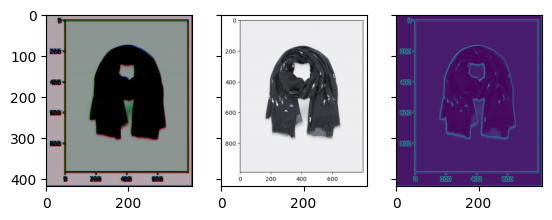

0.16348017752170563
0.1634627729654312
0.163445383310318
0.16342797875404358
0.16341064870357513
0.16339333355426788
0.16337603330612183
0.16335877776145935
0.16334150731563568
0.16332431137561798
0.16330713033676147
0.16328993439674377
0.16327276825904846
0.16325566172599792
0.16323858499526978
0.16322149336338043
0.16320443153381348
0.1631873995065689
0.16317039728164673
0.16315340995788574
0.16313642263412476
0.16311949491500854
0.16310261189937592
0.1630856841802597
0.16306884586811066
0.16305199265480042
0.16303518414497375
0.16301840543746948
0.16300161182880402
0.16298486292362213
0.16296812891960144
0.16295145452022552
0.16293475031852722
0.1629180908203125
0.16290141642093658
0.16288480162620544
0.1628682166337967
0.16285163164138794
0.16283507645130157
0.1628185510635376
0.16280202567577362
0.16278550028800964
0.16276901960372925
0.16275256872177124
0.16273610293865204
0.1627196967601776
0.16270330548286438
0.16268692910671234
0.1626705527305603
0.16265425086021423
0.16263793

In [10]:
# Epoch loops (the number of times we see the training dataset)
for i in range(1000):

  for j in range(1): # iterate over the dataset (here one single image, should be more)

    # forward pass, compute the output of the network




    outputs = net(image)

    # compute the error (here mean square error)
    loss = F.mse_loss(outputs, image)

    # reinitialize the gradients
    optimizer.zero_grad()

    # compute the gradients
    loss.backward()

    # update the weights
    optimizer.step()

    print(loss.item())

  # display the results
  if i%100 == 0:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    clear_output(wait=True)
    outputs_np = outputs.cpu().detach().numpy()[0].transpose(1,2,0)
    ax1.imshow(np.clip(outputs_np,0,1))
    ax2.imshow(im)
    ax3.imshow(((outputs_np-im)**2).sum(axis=2))
    plt.show()


# Denoising of data set

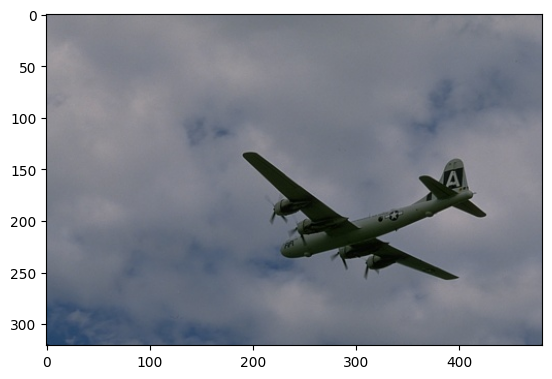

In [11]:
image_path = "/content/gdrive/MyDrive/Images/3096.jpg"
im = np.array(Image.open(image_path), dtype=float)/255

plt.figure()
plt.imshow(im)
plt.show()

In [12]:
# create the neural network with Pytorch
class Mynet(nn.Module):
  """Unet segmentation network."""

  def __init__(self, in_channels, out_channels):
    """Init Unet fields."""
    super(Mynet, self).__init__()

    # input channels
    self.in_channels = in_channels

    self.conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(3)


  def forward(self, x):
    """Forward method."""

    x = F.relu(self.bn(self.conv(x)))
    x = F.relu(self.bn2(self.conv2(x)))

    return x

In [13]:
# actual network creation
net = Mynet(3,3)
net.cuda() # go GPU

image = image.cuda() # go gpu for the image data


ValueError: operands could not be broadcast together with shapes (418,355,3) (321,481,3) 

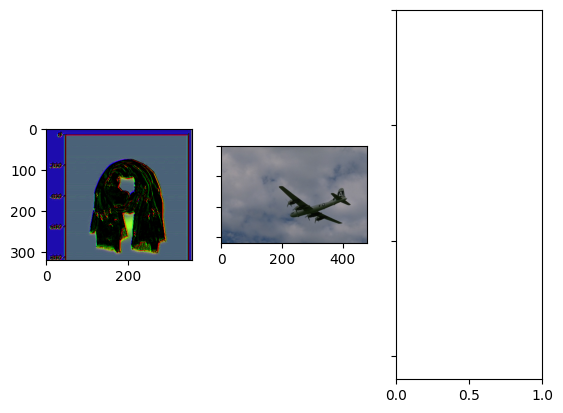

In [14]:
# create the optimizer
# lr learning rate
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
epoch=1000
# Epoch loops (the number of times we see the training dataset)


for i in range(epoch):

  for j in range(1): # iterate over the dataset (here one single image, should be more)

    # forward pass, compute the output of the network

    outputs = net(image)

    # compute the error (here mean square error)
    loss = F.mse_loss(outputs, image)

    # reinitialize the gradients
    optimizer.zero_grad()

    # compute the gradients
    loss.backward()

    # update the weights
    optimizer.step()

    print(loss.item())

  # display the results
  if i%100 == 0:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    clear_output(wait=True)
    outputs_np = outputs.cpu().detach().numpy()[0].transpose(1,2,0)
    ax1.imshow(np.clip(outputs_np,0,1))
    ax2.imshow(im)
    ax3.imshow(((outputs_np-im)**2).sum(axis=2))
    plt.show()


## Creation of data set

In [ ]:
# Data Loading
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

